In [1]:
from IPython.core.display import display, HTML
display(HTML("<style>.container { width:90% !important; }</style>"))
%config Completer.use_jedi = False  # to make autocompletion faster

/var/folders/nb/v61jd0_j06bbnbf079ftm75c0000gn/T/ipykernel_42192/1761094475.py:1: DeprecationWarning: Importing display from IPython.core.display is deprecated since IPython 7.14, please import from IPython display
  from IPython.core.display import display, HTML


In [2]:
import sys
print(sys.version)

3.10.9 | packaged by conda-forge | (main, Feb  2 2023, 20:26:08) [Clang 14.0.6 ]


In [3]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow import keras
import gc


In [4]:
tf.__version__

'2.9.2'

In [5]:
tf.config.experimental.list_physical_devices('GPU')

[PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]

## Load dataset

In [6]:
from webtraffic.webtraffic_utils import (VizualizeResults, smape_np, SmapeLoss, 
                                         estimated_autocorrelation, plot_spectrest)
from webtraffic.inout import load_data, training_dataset
output_len = 62

In [7]:
df_ds = load_data()

In [8]:
dataset = training_dataset(df_ds)

In [9]:
(X_train, Y_train), (X_test, Y_test) = dataset.get_training_datasets()

## Exploration

Metal device set to: Apple M1


2023-04-04 16:41:18.263133: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:305] Could not identify NUMA node of platform GPU ID 0, defaulting to 0. Your kernel may not have been built with NUMA support.
2023-04-04 16:41:18.263752: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:271] Created TensorFlow device (/job:localhost/replica:0/task:0/device:GPU:0 with 0 MB memory) -> physical PluggableDevice (device: 0, name: METAL, pci bus id: <undefined>)


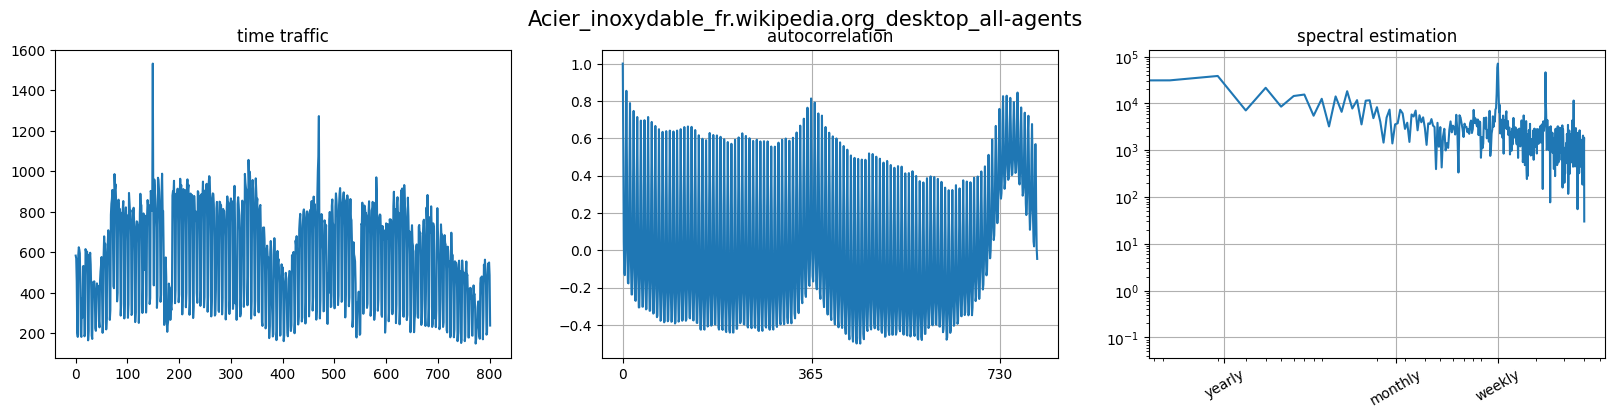

In [13]:
# remarkable pages

rem_pages = [
    'Acier_inoxydable_fr.wikipedia.org_desktop_all-agents',
]
#rem_pages = df_ds.loc[weekly_tone & (df_feat["access"] == "desktop_all-agents")].index

page = rem_pages[0]
traffic_t =  df_ds.loc[page].values[:-1].astype(int)
f,vax = plt.subplots(1,3, figsize=(20,4))
fax = vax.flat


ax=next(fax)
ax.plot(traffic_t)
ax.set_title("time traffic")


ax=next(fax)
ax.plot(estimated_autocorrelation(traffic_t))
ax.set_xticks([0,365,2*365])
ax.set_title("autocorrelation")
ax.grid()

ax=next(fax)
plot_spectrest(traffic_t, ax)
ax.set_title("spectral estimation")

plt.suptitle(page, fontsize=15)
plt.show()

## Models

[median value](#median-value-repeated)  
[dense model](#dense-model)  
[RNN](#RNN)  

### median value repeated

In [15]:
from webtraffic.models.median_model import median_model

med = median_model(dataset)
med.fit()

train_pred = med.predict(X_train)
test_pred = med.predict(X_test)

print(pd.Series(index=["train", "test"],
                data=[smape_np(train_pred, Y_train.values),
                      smape_np(test_pred, Y_test.values)]))

train    40.493291
test     40.950504
dtype: float64


Text(0.5, 1.0, 'SMAPE: 45.3')

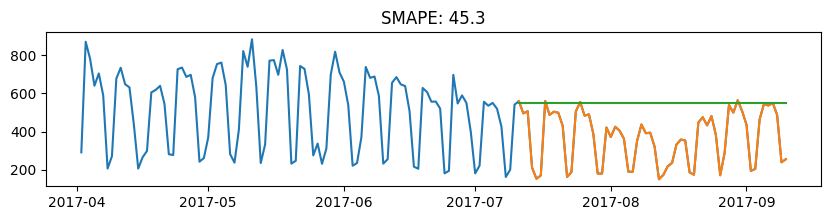

In [16]:
vr = VizualizeResults(df_ds, nsamp_before=100)

all_samples, y_true, y_pred = vr.get_aligned_results(Y_test, test_pred)

f, ax = plt.subplots(figsize=(10,2))
ax.plot(all_samples)
ax.plot(y_true)
ax.plot(y_pred)
ax.set_title(f"SMAPE: {vr.get_smape(Y_test, test_pred):.1f}")

In [17]:
def _smape_row(A, F):
    return np.mean(100 * (2 * np.abs(F - A) / (np.abs(A) + np.abs(F) + np.finfo(float).eps)), axis=1)


smapes = pd.Series(_smape_row(test_pred, Y_test.values), index=Y_train.index, name="smapes")
perfs = pd.concat([smapes, X_train.median(axis=1).rename("medians"), X_train.std(axis=1).rename("stds")], axis=1)

In [18]:
perfs.groupby(pd.cut(perfs.medians, [0,10,100,1000,10000,1000000]))["smapes"].aggregate([np.mean, 'count'])

,mean,count
medians,,
"(0, 10]",59.579328,24395
"(10, 100]",41.774774,37104
"(100, 1000]",34.655091,53051
"(1000, 10000]",29.458161,19726
"(10000, 1000000]",27.348487,618


### dense model

In [21]:
from webtraffic.models.dense_model import dense_model
from webtraffic.webtraffic_utils import create_tb_cb


dense = dense_model(dataset, epochs=2)
dense.model.summary()

Model: "model_1"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 traffic (InputLayer)           [(None, 100)]        0           []                               
                                                                                                  
 dense_1 (Dense)                (None, 62)           6262        ['traffic[0][0]']                
                                                                                                  
 std (InputLayer)               [(None, 1)]          0           []                               
                                                                                                  
 tf.math.multiply_1 (TFOpLambda  (None, 62)          0           ['dense_1[0][0]',                
 )                                                                'std[0][0]']              

In [22]:
dense.fit()

Epoch 1/2


2023-04-04 16:45:13.323150: W tensorflow/core/platform/profile_utils/cpu_utils.cc:128] Failed to get CPU frequency: 0 Hz
2023-04-04 16:45:13.514091: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


4534/4534 [==============================] - ETA: 0s - loss: 45.1228 - smape: 46.8536

2023-04-04 16:45:37.498099: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


4534/4534 [==============================] - 40s 9ms/step - loss: 45.1228 - smape: 46.8536 - val_loss: 43.1211 - val_smape: 45.0123
Epoch 2/2
4534/4534 [==============================] - 40s 9ms/step - loss: 38.7340 - smape: 40.6543 - val_loss: 41.2254 - val_smape: 43.1895


In [23]:
test_pred = linmod.predict(X_test)
train_pred = linmod.predict(X_train)

  76/4534 [..............................] - ETA: 9s

2023-04-04 16:46:34.156978: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


4534/4534 [==============================] - 9s 2ms/step


In [24]:
print(pd.Series(index=["train", "test"],
                data=[smape_np(train_pred, Y_train.values),
                      smape_np(test_pred, Y_test.values)]))

train    60.331335
test     58.839908
dtype: float64


Text(0.5, 1.0, 'train SMAPE: 52.9')

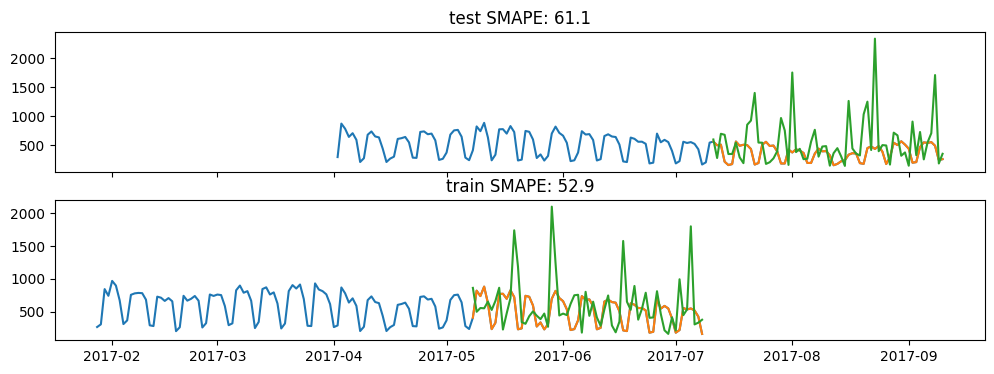

In [25]:

vr = VizualizeResults(df_ds, nsamp_before=100)

all_samples, y_true, y_pred = vr.get_aligned_results(Y_test, test_pred)
tr_samples, tr_true, tr_pred = vr.get_aligned_results(Y_train, train_pred)

f, vax = plt.subplots(2,1,figsize=(12,4), sharex=True)

ax=vax[0]
ax.plot(all_samples)
ax.plot(y_true)
ax.plot(y_pred)
ax.set_title(f"test SMAPE: {vr.get_smape(Y_test, test_pred):.1f}")

ax=vax[1]
ax.plot(tr_samples)
ax.plot(tr_true)
ax.plot(tr_pred)
ax.set_title(f"train SMAPE: {vr.get_smape(Y_train, train_pred):.1f}")


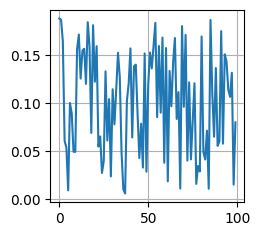

In [26]:
weights = linmod.model.get_layer("dense").get_weights()[0]

f,ax = plt.subplots(figsize=(2.5,2.5))
ax.plot(np.abs(weights[:,0]))
ax.grid()

### RNN

In [27]:
#!rm -Rf logs/*

In [28]:
from webtraffic.models.rnn_model import rnn_model

rnn = rnn_model(dataset, epochs=1)
rnn.model.summary()

Model: "model_2"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 time_datas (InputLayer)        [(None, 50, 17)]     0           []                               
                                                                                                  
 gru0 (GRU)                     (None, 50, 30)       4410        ['time_datas[0][0]']             
                                                                                                  
 std (InputLayer)               [(None, 1)]          0           []                               
                                                                                                  
 batch_normalization (BatchNorm  (None, 50, 30)      120         ['gru0[0][0]']                   
 alization)                                                                                 

In [29]:
rnn.fit()

2023-04-04 16:47:45.859384: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.
2023-04-04 16:47:46.578167: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.
2023-04-04 16:47:47.338487: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


4534/4534 [==============================] - ETA: 0s - loss: 41.7374 - smape: 42.3355

2023-04-04 16:49:24.835032: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.
2023-04-04 16:49:24.972961: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


4534/4534 [==============================] - 108s 23ms/step - loss: 41.7374 - smape: 42.3355 - val_loss: 40.7387 - val_smape: 42.1100


In [30]:
test_pred = rnn.predict(X_test)
train_pred = rnn.predict(X_train)
print(pd.Series(index=["train", "test"],
                data=[smape_np(train_pred, Y_train.values),
                      smape_np(test_pred, Y_test.values)]))

  1/142 [..............................] - ETA: 37s

2023-04-04 16:49:52.295443: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.
2023-04-04 16:49:52.333015: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


142/142 [==============================] - 3s 23ms/step
train    39.159485
test     40.808407
dtype: float64


In [31]:
def _smape_row(A, F):
    return np.mean(100 * (2 * np.abs(F - A) / (np.abs(A) + np.abs(F) + np.finfo(float).eps)), axis=1)


smapes = pd.Series(_smape_row(train_pred, Y_train.values), index=Y_train.index, name="smapes")
perfs = pd.concat([smapes, X_train.median(axis=1).rename("medians"), X_train.std(axis=1).rename("stds")], axis=1)

perfs.groupby(pd.cut(perfs.medians, [0,10,100,1000,10000,1000000]))["smapes"].mean()

medians
(0, 10]             58.125372
(10, 100]           39.199021
(100, 1000]         32.646710
(1000, 10000]       27.420082
(10000, 1000000]    25.537087
Name: smapes, dtype: float64

In [32]:
perf_smp = perfs.sample(10000)

Text(0.5, 0, 'std dev')

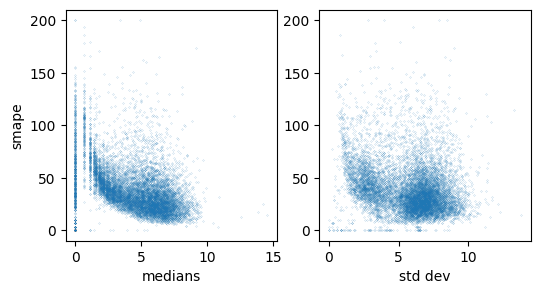

In [33]:
f, (ax, ax1) = plt.subplots(1,2, figsize=(6,3))
ax.scatter(np.log1p(perf_smp.medians), perf_smp.smapes, s=.01)
ax1.scatter(np.log1p(perf_smp.stds), perf_smp.smapes, s=.01)
ax.set_ylabel("smape")
ax.set_xlabel("medians")
ax1.set_xlabel("std dev")

Text(0.5, 1.0, 'train SMAPE: 40.5')

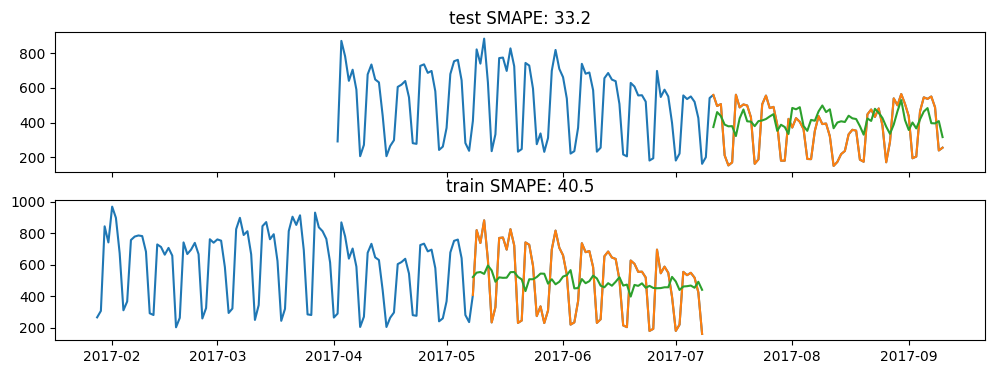

In [34]:
vr = VizualizeResults(df_ds, nsamp_before=100)

all_samples, y_true, y_pred = vr.get_aligned_results(Y_test, test_pred)
tr_samples, tr_true, tr_pred = vr.get_aligned_results(Y_train, train_pred)

f, vax = plt.subplots(2,1,figsize=(12,4), sharex=True)

ax=vax[0]
ax.plot(all_samples)
ax.plot(y_true)
ax.plot(y_pred)
ax.set_title(f"test SMAPE: {vr.get_smape(Y_test, test_pred):.1f}")

ax=vax[1]
ax.plot(tr_samples)
ax.plot(tr_true)
ax.plot(tr_pred)
ax.set_title(f"train SMAPE: {vr.get_smape(Y_train, train_pred):.1f}")


### test on synthesized datas

In [44]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from webtraffic.webtraffic_utils import (VizualizeResults, smape_np, SmapeLoss, 
                                         estimated_autocorrelation, plot_spectrest)
from webtraffic.inout import load_data, training_dataset
from webtraffic.models.rnn_model import rnn_model
output_len = 62

In [ ]:
df_ds = load_data()

<Axes: >

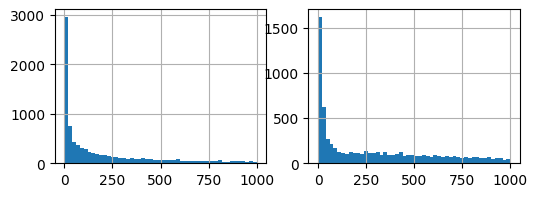

In [38]:
Ns=10000
samp = df_ds.sample(Ns, random_state=34)

medians = samp.median(axis=1).rename("median")
stds = samp.std(axis=1).rename("std")

f, (ax, ax1) = plt.subplots(1,2,figsize=(6,2))
medians.hist(range=(0,1000), ax=ax, bins=50)
stds.hist(range=(0,1000),ax=ax1, bins=50)
#ax.set_xscale("log")
#ax.set_yscale("log")

In [39]:
Ns=10000
phase0 = np.random.uniform(0,1,size=(Ns,1))
phases = (np.arange(0,df_ds.shape[1])/ 7).reshape(1,-1) + phase0
means =  medians.values.reshape(-1,1) # np.random.randint(0, 400 , (Ns,1)) 
amplis = np.min( [stds.values.reshape(-1,1) / 3. , means], axis=0)# means * np.random.uniform(0, 1, size=means.shape) 
data_synth = np.sin(2 * np.pi * phases) * amplis + means
noise = np.random.randn(Ns, df_ds.shape[1]) * means / 10.
data_synth = np.clip(data_synth + noise, a_min=0, a_max=None) 

In [40]:
(np.random.randn(Ns, df_ds.shape[1]) * means).std(axis=1)

array([418.92850784,  70.9708035 , 416.2011634 , ..., 118.71744158,
       159.77238228,  10.29975477])

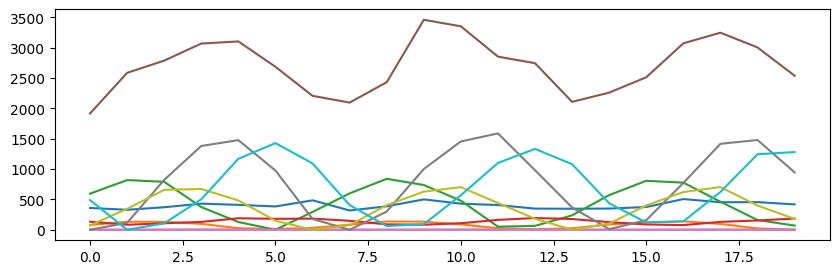

In [41]:
f, ax = plt.subplots(figsize=(10,3))
ax.plot(data_synth[:10,:20].T)
plt.show()

In [42]:
df_synth = pd.DataFrame(data=data_synth,
                        index = samp.index,
                       columns=df_ds.columns)

In [47]:
ds_synth = training_dataset(df_synth)
(X_train, Y_train), (X_test, Y_test) = ds_synth.get_training_datasets()

In [50]:
model = rnn_model(ds_synth, epochs=5)
model.fit()

Epoch 1/5


2023-04-04 16:55:32.673922: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.
2023-04-04 16:55:33.375072: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


  1/313 [..............................] - ETA: 7:48 - loss: 75.3575 - smape: 78.1478

2023-04-04 16:55:33.615549: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


313/313 [==============================] - ETA: 0s - loss: 35.9430 - smape: 42.2604

2023-04-04 16:55:40.521675: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.
2023-04-04 16:55:40.654583: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


313/313 [==============================] - 9s 25ms/step - loss: 35.9430 - smape: 42.2604 - val_loss: 24.9529 - val_smape: 31.5017
Epoch 2/5
313/313 [==============================] - 7s 23ms/step - loss: 21.6919 - smape: 28.4847 - val_loss: 20.6484 - val_smape: 27.5793
Epoch 3/5
313/313 [==============================] - 8s 24ms/step - loss: 20.0718 - smape: 27.1220 - val_loss: 19.6774 - val_smape: 26.2608
Epoch 4/5
313/313 [==============================] - 7s 23ms/step - loss: 19.5053 - smape: 26.6264 - val_loss: 19.2337 - val_smape: 26.4906
Epoch 5/5
313/313 [==============================] - 7s 23ms/step - loss: 19.1409 - smape: 27.1147 - val_loss: 18.9020 - val_smape: 27.4258


In [51]:
test_pred = model.predict(X_test)
train_pred = model.predict(X_train)
print(pd.Series(index=["train", "test"],
                data=[smape_np(train_pred, Y_train.values),
                      smape_np(test_pred, Y_test.values)]))

2023-04-04 16:56:14.771279: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.
2023-04-04 16:56:14.813981: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


10/10 [==============================] - 0s 23ms/step
train    49.759271
test     49.684614
dtype: float64


(0.0, 600.9545120369839)

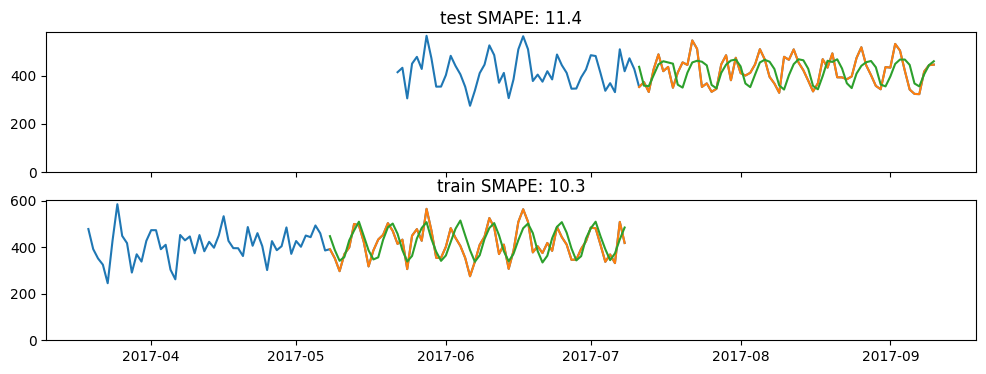

In [52]:
vr = VizualizeResults(df_synth, nsamp_before=50, page=df_synth.index[0])

all_samples, y_true, y_pred = vr.get_aligned_results(Y_test, test_pred)
tr_samples, tr_true, tr_pred = vr.get_aligned_results(Y_train, train_pred)

f, vax = plt.subplots(2,1,figsize=(12,4), sharex=True)

ax=vax[0]
ax.plot(all_samples)
ax.plot(y_true)
ax.plot(y_pred)
ax.set_title(f"test SMAPE: {vr.get_smape(Y_test, test_pred):.1f}")
ax.set_ylim(bottom=0)

ax=vax[1]
ax.plot(tr_samples)
ax.plot(tr_true)
ax.plot(tr_pred)
ax.set_title(f"train SMAPE: {vr.get_smape(Y_train, train_pred):.1f}")
ax.set_ylim(bottom=0)


#### error analysis

In [53]:
smapes = pd.Series([smape_np(test_pred[ii,:], Y_test.iloc[ii,:]) for ii in range(test_pred.shape[0])],
                  index=Y_test.index, name="smapes"
                  )

In [55]:
%matplotlib inline

Text(0.5, 0, 'std dev')

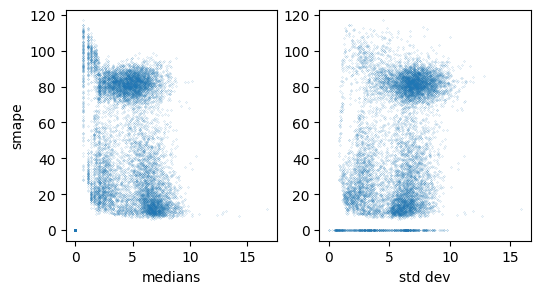

In [56]:
f, (ax, ax1) = plt.subplots(1,2, figsize=(6,3))
ax.scatter(np.log1p(medians), smapes, s=.01)
ax1.scatter(np.log1p(stds), smapes, s=.01)
ax.set_ylabel("smape")
ax.set_xlabel("medians")
ax1.set_xlabel("std dev")

In [57]:
np.mean(smapes.loc[medians!=1])

48.95423227614721

In [58]:
pd.concat([smapes, medians, stds], axis=1).sort_values(by="smapes")

,smapes,median,std
Page,,,
File:The_Royal_Navy_during_the_Second_World_War_A3722.jpg_commons.wikimedia.org_mobile-web_all-agents,0.000000,0.0,165.695136
Commons:Wiki_Loves_Monuments_2016_in_the_United_States/Upload_commons.wikimedia.org_mobile-web_all-agents,0.000000,0.0,34.368726
我獨自生活_zh.wikipedia.org_all-access_all-agents,0.000000,0.0,484.101251
Help:Patrolled_edits/fr_www.mediawiki.org_mobile-web_all-agents,0.000000,0.0,3.296645
Topic:Sz8rvjba84dgh78h_www.mediawiki.org_mobile-web_all-agents,0.000000,0.0,2.551137
...,...,...,...
Четыре_свободы_ru.wikipedia.org_desktop_all-agents,113.172405,1.0,2437.439618
Special:History/Help:Categories_www.mediawiki.org_mobile-web_all-agents,114.049105,1.0,4.170584
2012_Summit_League_Men's_Basketball_Tournament_en.wikipedia.org_all-access_all-agents,114.224268,1.0,5.329341


(0.0, 2.3372000615476556)

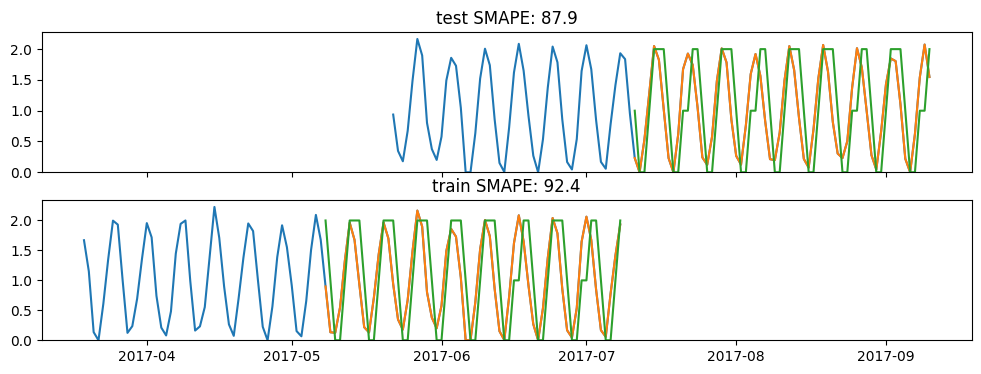

In [59]:
vr = VizualizeResults(df_synth, nsamp_before=50, 
                      page="Commons:Wiki_Loves_Monuments_2016_in_Malaysia_commons.wikimedia.org_all-access_all-agents")

all_samples, y_true, y_pred = vr.get_aligned_results(Y_test, test_pred)
tr_samples, tr_true, tr_pred = vr.get_aligned_results(Y_train, train_pred)

f, vax = plt.subplots(2,1,figsize=(12,4), sharex=True)

ax=vax[0]
ax.plot(all_samples)
ax.plot(y_true)
ax.plot(y_pred)
ax.set_title(f"test SMAPE: {vr.get_smape(Y_test, test_pred):.1f}")
ax.set_ylim(bottom=0)

ax=vax[1]
ax.plot(tr_samples)
ax.plot(tr_true)
ax.plot(tr_pred)
ax.set_title(f"train SMAPE: {vr.get_smape(Y_train, train_pred):.1f}")
ax.set_ylim(bottom=0)
